In [64]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.optim as optim

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [66]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.data) - self.seq_length - 11
    
    def __getitem__(self, idx):
        a = torch.tensor(self.data[idx:idx+self.seq_length+10],dtype=torch.float32)
        b = torch.tensor(np.cumsum([i[1]/30 for i in self.data[idx:idx+self.seq_length+10]]) - 1,dtype=torch.float32)
        x = torch.cat((a,b.unsqueeze(1)),dim=1)
        y = torch.tensor(self.data[idx+self.seq_length:idx+self.seq_length + 10,0],dtype=torch.float32)
        return x, y

In [67]:
import random

train_x = []

for i in range(12000):
    if random.random() < 0.5:
        if len(train_x):
            train_x.append([np.sin(0.0943*i),i-old_i])
            old_i = i
        else:
            train_x.append([np.sin(0.0943*i),1])
            old_i = i

train_x = torch.tensor(train_x,dtype=torch.float32)

In [68]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(80, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        self.mask = np.nonzero

    def forward(self, x):
        x = torch.cat((torch.flatten(x[:,:20],start_dim=1),torch.flatten(x[:,20:,1:],start_dim=1)),dim=1)
        #x = self.flatten(x)0.0943
        logits = self.linear_relu_stack(x)
        return logits

In [69]:
model = NeuralNetwork().to(device)
print(model)
print("Number of trainable parameters:",sum(p.numel() for p in model.parameters()))

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=80, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Number of trainable parameters: 309258


In [70]:

seq_length = 20

dataset = TimeSeriesDataset(train_x, seq_length=seq_length)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

#criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95)

print("Number of trainable parameters:",sum(p.numel() for p in model.parameters()))

num_epochs = 100
for epoch in range(num_epochs):
    losses = []
    for x, y in dataloader:
        optimizer.zero_grad()
        y_pred = model(x)
        #print(y_pred.shape,y.shape)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print('Epoch:', epoch+1, 'Loss:', np.mean(losses))#,scheduler.get_last_lr())
    scheduler.step()

Number of trainable parameters: 309258


/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_90251/2393772794.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(self.data[idx:idx+self.seq_length+10],dtype=torch.float32)
/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_90251/2393772794.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.data[idx+self.seq_length:idx+self.seq_length + 10,0],dtype=torch.float32)


Epoch: 1 Loss: 0.23035696125344227
Epoch: 2 Loss: 0.08249119551558244
Epoch: 3 Loss: 0.05610961831713977
Epoch: 4 Loss: 0.04680293735704924
Epoch: 5 Loss: 0.03882065174218855
Epoch: 6 Loss: 0.03485356137940758
Epoch: 7 Loss: 0.032271340979557285
Epoch: 8 Loss: 0.030496087278190413
Epoch: 9 Loss: 0.028188389657359373
Epoch: 10 Loss: 0.026803523302078247
Epoch: 11 Loss: 0.02439115739574558
Epoch: 12 Loss: 0.022672498500660845
Epoch: 13 Loss: 0.020831025136928808
Epoch: 14 Loss: 0.0210129461790386
Epoch: 15 Loss: 0.020708697897038962
Epoch: 16 Loss: 0.018113270725466705
Epoch: 17 Loss: 0.018422100751807814
Epoch: 18 Loss: 0.017221287059548653
Epoch: 19 Loss: 0.016472342796623705
Epoch: 20 Loss: 0.015682316983216687
Epoch: 21 Loss: 0.015965239723262033
Epoch: 22 Loss: 0.014485385386567367
Epoch: 23 Loss: 0.01400434454216769
Epoch: 24 Loss: 0.014647510736004302
Epoch: 25 Loss: 0.01308106994746547
Epoch: 26 Loss: 0.012681930335728746
Epoch: 27 Loss: 0.012024017158699662
Epoch: 28 Loss: 0.011

In [71]:
test_x = []

for i in range(300):
    if random.random() < 0.5:
        if len(test_x):
            test_x.append([np.sin(0.0943*i + 566),i-old_i])
            old_i = i
        else:
            test_x.append([np.sin(0.0943*i + 566),1])
            old_i = i

test_x = torch.tensor(test_x,dtype=torch.float32)

torch.Size([1, 30, 3])


/var/folders/wy/k9h01g4j2yg_jky8w6rsfsjm0000gn/T/ipykernel_90251/2808683711.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(test_x[k:k+30],dtype=torch.float32)


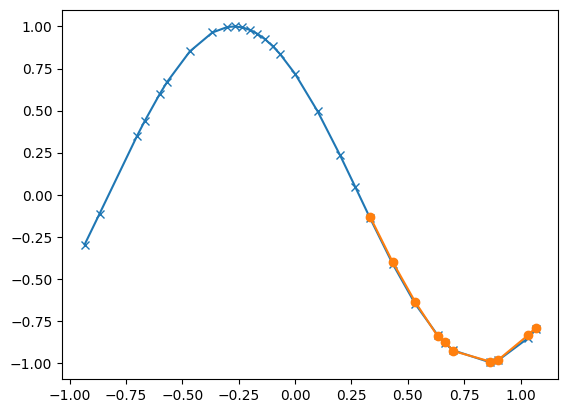

In [84]:
k = random.randint(0,50)

a = torch.tensor(test_x[k:k+30],dtype=torch.float32)
b = torch.tensor(np.cumsum([i[1]/30 for i in test_x[k:k+30]]) - 1,dtype=torch.float32)
x = torch.cat((a,b.unsqueeze(1)),dim=1)
x[20:,0] = 0
sample = torch.cat((a,b.unsqueeze(1)),dim=1).unsqueeze(0)

y = torch.tensor(test_x[k+30:k+40,0],dtype=torch.float32)

print(sample.shape)

pred_y = model(sample)

import matplotlib.pyplot as plt

# plt.plot(torch.cumsum(sample[0,:,1],dim=0),sample[0,:,0],"x")
# plt.plot(torch.cumsum(sample[0,:,1],dim=0)[20:],pred_y[0].tolist(),"o")

plt.plot(sample[0,:,2],sample[0,:,0],"-x")
plt.plot(sample[0,20:,2],pred_y[0].tolist(),"-o")

In [73]:
pred_y[0].tolist()

[0.835728645324707,
 0.7180935144424438,
 0.5191709399223328,
 0.23973949253559113,
 0.06507150083780289,
 -0.11916134506464005,
 -0.39406150579452515,
 -0.6376503705978394,
 -0.8532272577285767,
 -0.891106903553009]

In [74]:
sample[0,:,1]

tensor([1., 2., 1., 3., 1., 2., 2., 5., 1., 2., 1., 3., 3., 2., 1., 1., 1., 1.,
        1., 1., 1., 2., 3., 3., 2., 2., 3., 3., 3., 1.])

In [75]:
import numpy as np

train_x = []
train_y = []

np.random.seed(0)

x = np.linspace(0,1,20)
y = np.linspace(1,1.5,10)

for i in range(3000):
    offset = np.random.rand()
    train_x.append(np.sin(x + offset))
    train_y.append(np.sin(y + offset))

train_x = torch.tensor(train_x,dtype=torch.float32)
train_y = torch.tensor(train_y,dtype=torch.float32)


In [76]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)
    
train_dataloader = DataLoader(MyDataset(train_x,train_y), batch_size=64, shuffle=True)

In [77]:
from torch.optim import Adam

# loss function and optimizer
loss_fn = nn.MSELoss() 
optimizer = Adam(model.parameters(), lr=0.001)

n_epochs = 10

for epoch in range(n_epochs):
    for x,y in train_dataloader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()

        print(loss.item())

IndexError: too many indices for tensor of dimension 2

In [ ]:
test_x = []
test_y = []

x = np.linspace(0,1,20)
y = np.linspace(1,1.5,10)

for i in range(1):
    offset = np.random.rand()
    test_x.append(np.sin(x + offset))
    test_y.append(np.sin(y + offset))

test_x = torch.tensor(test_x,dtype=torch.float32)
test_y = torch.tensor(test_y,dtype=torch.float32)

pred_y = model(test_x)

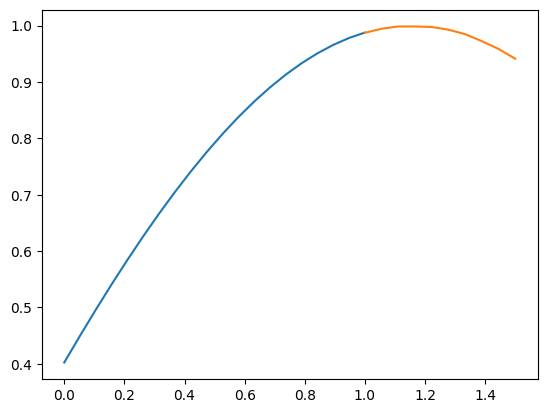

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x,test_x[0])
plt.plot(y,pred_y[0].tolist())